# 신용카드 거래 데이터는 전형적인 불균형 데이터셋. 정상 거래가 압도적으로 많고(0), 사기 거래(1)는 매우 드물다.



## 신용카드 거래 데이터 샘플

- Time: 각 거래와 첫 거래 사이의 시간 (초 단위)
- V1 ~ V28: 개인 정보 보호를 위해 PCA 변환된 피처들 (실제 의미는 알 수 없다)
- Amount: 거래 금액
- Class: 사기 거래인 경우 1, 그렇지 않은 경우 0

| Time (초) | V1...V28 (변환된 피처) | Amount (거래 금액) | Class (0: 정상, 1: 사기) |
| --- | --- | --- | --- |
| 0 | V1: 0.82, V2: -0.19, ..., V28: 0.05 | 4.99 | **0 (정상)** |
| 1 | V1: -0.65, V2: 0.15, ..., V28: -0.01 | 16.00 | **0 (정상)** |
| 2 | V1: -0.13, V2: 0.17, ..., V28: -0.17 | 10.99 | **0 (정상)** |
| 3 | V1: 1.15, V2: 0.53, ..., V28: 0.11 | 2.50 | **0 (정상)** |
| 4 | V1: -0.96, V2: 0.25, ..., V28: -0.05 | 7.99 | **0 (정상)** |
| **5** | **V1: -1.78, V2: 3.12, ..., V28: 0.44** | **1.00** | **1 (사기)** |
| 6 | V1: 0.99, V2: -0.56, ..., V28: 0.03 | 55.00 | **0 (정상)** |
| 7 | V1: -0.55, V2: 0.29, ..., V28: 0.01 | 30.50 | **0 (정상)** |
| 8 | V1: 1.05, V2: 0.42, ..., V28: 0.07 | 12.00 | **0 (정상)** |
| **9** | **V1: -0.42, V2: 2.15, ..., V28: 0.29** | **4.99** | **1 (사기)** |

---

## 데이터셋의 특징 분석

### 1. 극심한 불균형 (Imbalance)실제 신용카드 사기 거래 데이터셋은 보통 다음과 같은 비율을 가진다.

* **전체 거래 수:** 약 285,000건
* **정상 거래 (Class 0):** 약 284,315건 (약 **99.83%**)
* **사기 거래 (Class 1):** 약 492건 (약 **0.17%**)

이처럼 사기 거래는 전체 데이터의 1%도 되지 않아, 모델이 사기 거래를 모두 놓치고 "모두 정상"이라고 예측하더라도 99.83%의 정확도를 달성할 수 있다. 이것이 바로 **정확도(Accuracy)를 신뢰할 수 없고 재현율(Recall)이 중요해지는 이유**.

### 2. 피처 (Feature) 구성실제 분석에서 사용되는 피처는 크게 세 가지 유형으로 나눈다.

* **Time (시간):** 첫 거래 이후 경과된 시간(초)을 나타냅니다. 사기 거래는 짧은 시간 내에 집중적으로 발생할 수 있다.
* **V1 ~ V28 (변환된 피처):** 민감한 카드 사용자 및 거래 정보를 **PCA(주성분 분석)**를 통해 변환하고 익명 처리한 결과입니다. 이 값들은 원본 데이터와 달리 해석이 어렵지만, 모델 학습에는 유용하게 사용된다.
* **Amount (거래 금액):** 거래 금액입니다. 사기 거래는 매우 적은 금액이거나, 오히려 매우 큰 금액으로 나타나는 등 패턴이 있을 수 있습.
* **Class (클래스):** 우리의 **타겟 변수(Target Variable)**입니다. 0은 정상, 1은 사기입니다.

이러한 불균형 문제를 해결하기 위해  **SMOTE, 클래스 가중치, 재현율 중심의 평가** 전략이 필요.


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split

sns.set_theme(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['font.family'] = 'Malgun Gothic'  # 한글 폰트 설정
rcParams['axes.unicode_minus']=False  # 마이너스 폰트 설정
rcParams['figure.figsize'] = 14, 8


In [11]:
# RANDOM_SEED와 LABELS 설정
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [12]:
df = pd.read_csv('../data/creditcard.csv')
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [13]:
df.shape

(284807, 31)

In [14]:
df.isnull().values.any()  # NumPy 배열의 모든 요소 중 True가 하나라도 있는지를 확인.

np.False_

In [15]:
LABELS

['Normal', 'Fraud']

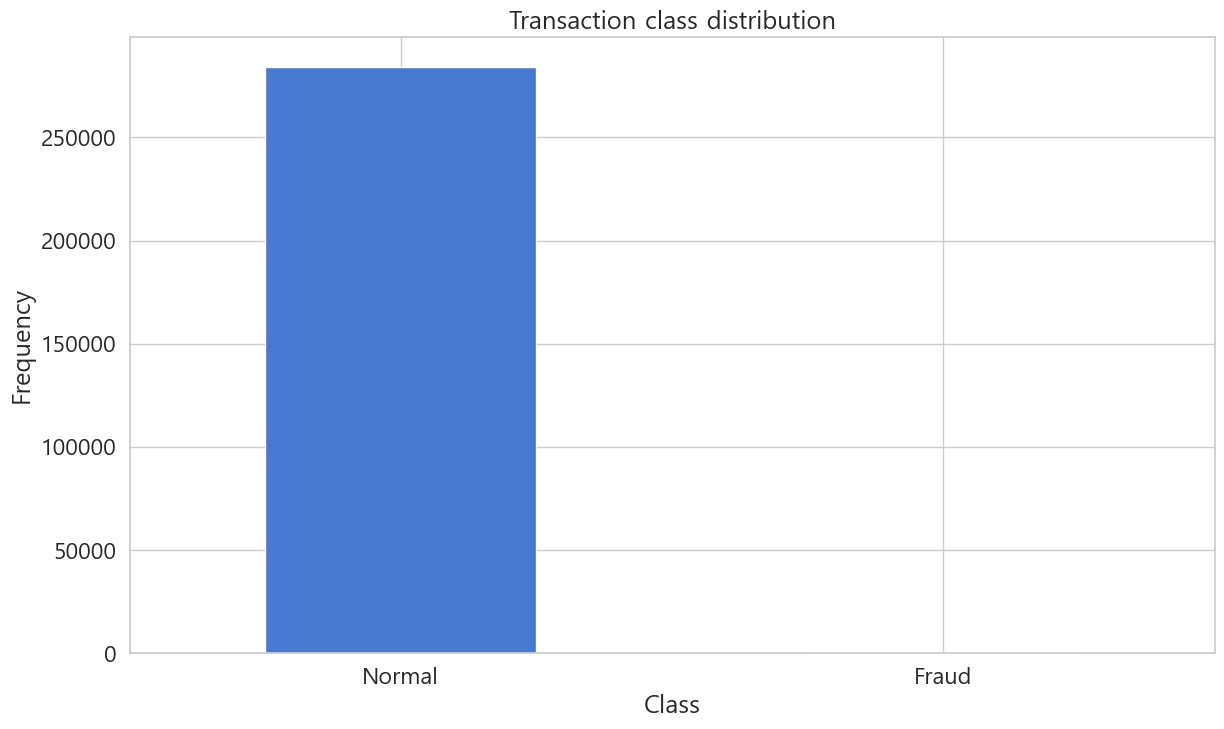

In [16]:
count_classes = df['Class'].value_counts()
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency");

In [17]:
frauds = df[df.Class == 1]
normal = df[df.Class == 0]
frauds.shape

(492, 31)

In [18]:
frauds['Amount'].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [19]:
normal['Amount'].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

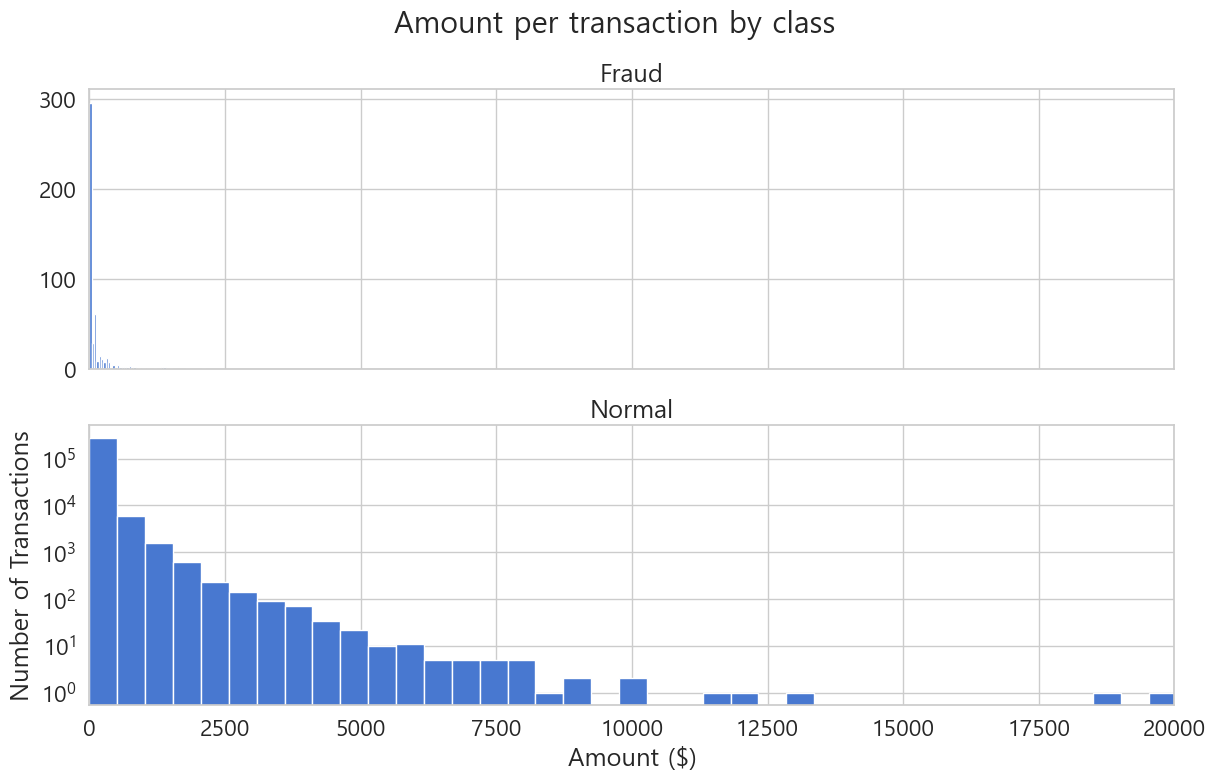

In [20]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(frauds.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

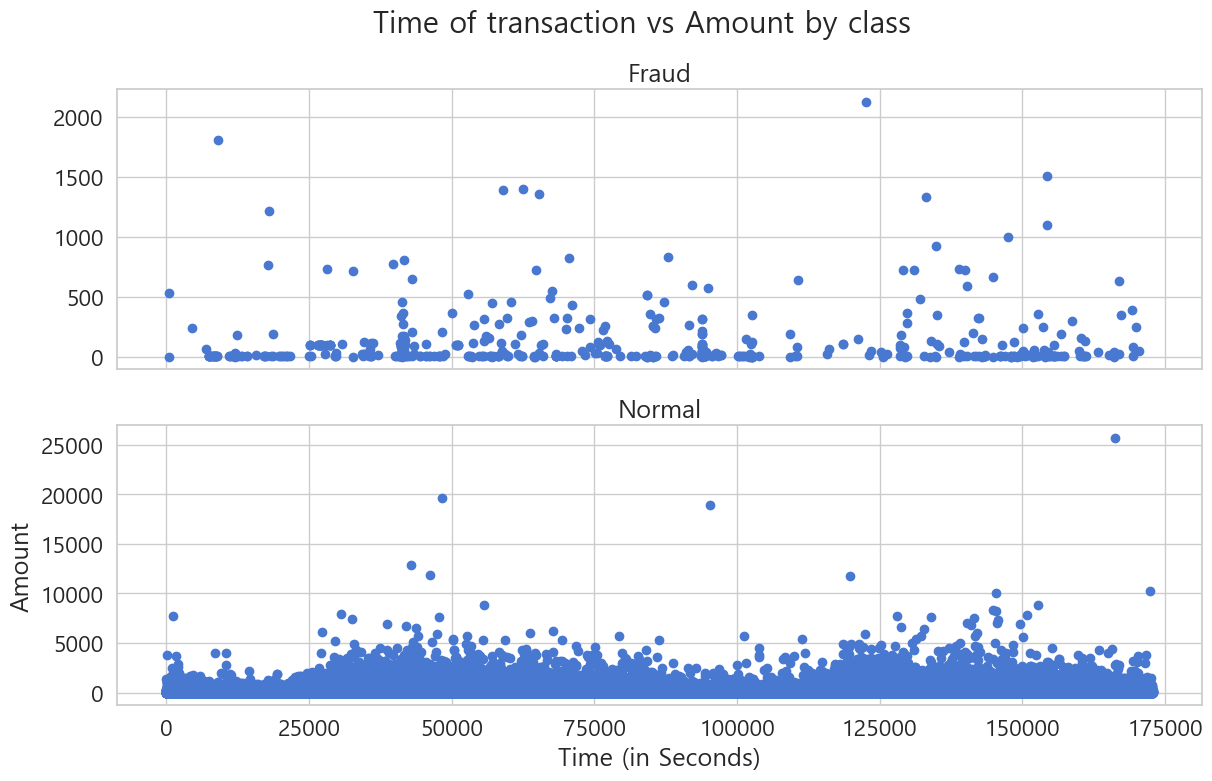

In [21]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(frauds.Time, frauds.Amount)
ax1.set_title('Fraud')

ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

In [22]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


In [23]:
df

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0


In [24]:
from sklearn.preprocessing import StandardScaler
data = df.drop(['Time'], axis=1)
scale_amount = StandardScaler() 
data['Amount'] = scale_amount.fit_transform( data['Amount'].values.reshape(-1, 1) )

In [25]:
x_data = data.drop(['Class'], axis=1) #data.drop(columns='Class')
y_data = data['Class']

In [26]:

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.3, random_state=42, stratify=y_data)


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix


# 모델 학습
model_baseline = LogisticRegression(random_state=42)
model_baseline.fit(X_train, y_train)

# 예측
y_pred_baseline = model_baseline.predict(X_test)

# 평가 지표
acc_base = accuracy_score(y_test, y_pred_baseline)
recall_base = recall_score(y_test, y_pred_baseline)
precision_base = precision_score(y_test, y_pred_baseline)
f1_base = f1_score(y_test, y_pred_baseline)

print("\n--- 2. 기준 모델 (No Handling) 결과 ---")
print(f"Accuracy:  {acc_base:.4f}")
print(f"Recall (재현율): {recall_base:.4f}") # 사기 거래를 놓치는 비율이 높을 수 있음
print(f"Precision: {precision_base:.4f}")
print(f"F1 Score:  {f1_base:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_baseline)}")


--- 2. 기준 모델 (No Handling) 결과 ---
Accuracy:  0.9992
Recall (재현율): 0.6149
Precision: 0.8585
F1 Score:  0.7165
Confusion Matrix:
[[85280    15]
 [   57    91]]


## 클래스 가중치 적용 (Algorithm-Level)
모델 학습 시 소수 클래스(사기)에 더 높은 가중치를 부여하여 모델이 소수 클래스의 오분류에 더 민감하게 반응하도록.

In [28]:
# LogisticRegression의 class_weight 파라미터를 'balanced'로 설정
model_weighted = LogisticRegression(class_weight='balanced', random_state=42)
model_weighted.fit(X_train, y_train)

# 예측
y_pred_weighted = model_weighted.predict(X_test)

# 평가 지표
recall_weighted = recall_score(y_test, y_pred_weighted)
precision_weighted = precision_score(y_test, y_pred_weighted)
f1_weighted = f1_score(y_test, y_pred_weighted)

print("\n--- 3. 클래스 가중치 (class_weight='balanced') 적용 결과 ---")
print(f"Recall (재현율): {recall_weighted:.4f}")
print(f"Precision: {precision_weighted:.4f}")
print(f"F1 Score:  {f1_weighted:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_weighted)}")

# 재현율(Recall)이 기준 모델보다 크게 향상되었을 것. 
# 이는 소수 클래스(사기)를 더 잘 잡아냈다는 의미. 
# 하지만 그 대가로 정밀도(Precision)는  하락 (정상 거래를 사기로 오인하는 경우 증가).


--- 3. 클래스 가중치 (class_weight='balanced') 적용 결과 ---
Recall (재현율): 0.8716
Precision: 0.0640
F1 Score:  0.1193
Confusion Matrix:
[[83409  1886]
 [   19   129]]


In [29]:
import sklearn
sklearn.__version__

'1.7.2'

## SMOTE 적용 (Data-Level)

In [30]:
from imblearn.over_sampling import SMOTE


# SMOTE 객체 생성
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n--- SMOTE 적용 후 학습 데이터 클래스 분포 ---")

print(f"SMOTE: {y_train_smote.value_counts()}")

# 모델 학습 (일반 LogisticRegression 사용)
model_smote = LogisticRegression(random_state=42)
model_smote.fit(X_train_smote, y_train_smote)

# 예측 (테스트 데이터는 원본 그대로 사용)
y_pred_smote = model_smote.predict(X_test)

# 평가 지표
recall_smote = recall_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)

print("\n--- 4. SMOTE 적용 결과 ---")
print(f"Recall (재현율): {recall_smote:.4f}")
print(f"Precision: {precision_smote:.4f}")
print(f"F1 Score:  {f1_smote:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_smote)}")


--- SMOTE 적용 후 학습 데이터 클래스 분포 ---
SMOTE: Class
0    199020
1    199020
Name: count, dtype: int64

--- 4. SMOTE 적용 결과 ---
Recall (재현율): 0.8784
Precision: 0.0620
F1 Score:  0.1158
Confusion Matrix:
[[83328  1967]
 [   18   130]]


## 재현율 중심의 평가 및 임계값 조정 (Evaluation)

In [31]:
# 가중치 모델의 예측 확률 확인 (사기 거래일 확률, Class 1)
y_prob_weighted = model_weighted.predict_proba(X_test)[:, 1]

# 새로운 임계값 설정 (재현율을 높이기 위해 0.5보다 낮은 값 시도)
NEW_THRESHOLD = 0.2

# 임계값을 0.2로 조정하여 예측 레이블 생성
y_pred_threshold = (y_prob_weighted >= NEW_THRESHOLD).astype(int)

# 평가 지표
recall_thresh = recall_score(y_test, y_pred_threshold)
precision_thresh = precision_score(y_test, y_pred_threshold)
f1_thresh = f1_score(y_test, y_pred_threshold)

print(f"\n--- 5. 임계값 조정 (Threshold={NEW_THRESHOLD}) 결과 ---")
print(f"Recall (재현율): {recall_thresh:.4f}") # 0.5일 때보다 더 높아질 수 있음
print(f"Precision: {precision_thresh:.4f}")
print(f"F1 Score:  {f1_thresh:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_threshold)}")


--- 5. 임계값 조정 (Threshold=0.2) 결과 ---
Recall (재현율): 0.9054
Precision: 0.0189
F1 Score:  0.0371
Confusion Matrix:
[[78351  6944]
 [   14   134]]


## 랜덤 포레스트 (Random Forest) - 기본 강인성 및 클래스 가중치
랜덤 포레스트는 여러 개의 결정 트리를 만드는 과정에서 무작위 샘플링을 수행하기 때문에, 기본적으로 불균형 데이터에 로지스틱 회귀보다 강인한 성능을 보인다. 여기에 class_weight='balanced'를 적용하면 소수 클래스 예측 능력을 더욱 강화할 수 있다.

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix


# class_weight='balanced'를 적용한 랜덤 포레스트
rf_model = RandomForestClassifier(
    n_estimators=30,
    class_weight='balanced', # 소수 클래스에 높은 가중치 부여
    random_state=42
)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# 평가
recall_rf = recall_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf)

print("--- 2. 랜덤 포레스트 (가중치 적용) 결과 ---")
print(f"Recall (재현율): {recall_rf:.4f}")
print(f"Precision: {precision_rf:.4f}")
print(f"F1 Score:  {f1_rf:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_rf)}")

--- 2. 랜덤 포레스트 (가중치 적용) 결과 ---
Recall (재현율): 0.7095
Precision: 0.9813
F1 Score:  0.8235
Confusion Matrix:
[[85293     2]
 [   43   105]]


### AdaBoost
AdaBoost는 잘못 분류된 샘플에 더 높은 가중치를 부여하며 모델을 순차적으로 학습하는 부스팅(Boosting) 기법입니다. 소수 클래스 샘플을 잘못 분류했을 때 큰 가중치를 받게 되므로 불균형 데이터에 효과적

In [33]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# AdaBoost 모델
# 기본 Base Estimator (DecisionTreeClassifier)를 사용하여 학습
adaboost_model = AdaBoostClassifier(
    n_estimators=50,
    random_state=42
)
adaboost_model.fit(X_train, y_train)
y_pred_ada = adaboost_model.predict(X_test)

# 평가
recall_ada = recall_score(y_test, y_pred_ada)
precision_ada = precision_score(y_test, y_pred_ada)
f1_ada = f1_score(y_test, y_pred_ada)

print("\n--- 3. AdaBoost 결과 ---")
print(f"Recall (재현율): {recall_ada:.4f}")
print(f"Precision: {precision_ada:.4f}")
print(f"F1 Score:  {f1_ada:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_ada)}")


--- 3. AdaBoost 결과 ---
Recall (재현율): 0.6757
Precision: 0.7353
F1 Score:  0.7042
Confusion Matrix:
[[85259    36]
 [   48   100]]


### EasyEnsembleClassifier (불균형 데이터 특화 앙상블)
EasyEnsemble은 언더샘플링(Undersampling) 기반의 앙상블 기법입니다. 다수 클래스(정상 거래)를 여러 개의 작은 서브셋으로 분할하고, 소수 클래스(사기 거래) 전체와 각 서브셋을 결합하여 여러 개의 균형 잡힌 데이터셋을 생성합니다. 이렇게 학습된 여러 분류기의 결과를 조합하여 최종 예측을 수행합니다.

이는 다수 클래스 정보를 최대한 유지하면서도 균형 잡힌 학습 환경을 제공

In [34]:
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, confusion_matrix

# imblearn의 EasyEnsembleClassifier 사용
# n_estimators: 생성할 서브셋(모델)의 개수
ee_model = EasyEnsembleClassifier(
    n_estimators=10,
    random_state=42
)
ee_model.fit(X_train, y_train)
y_pred_ee = ee_model.predict(X_test)

# 평가
recall_ee = recall_score(y_test, y_pred_ee)
precision_ee = precision_score(y_test, y_pred_ee)
f1_ee = f1_score(y_test, y_pred_ee)

print("\n--- 4. EasyEnsembleClassifier 결과 (특화 기법) ---")
print(f"Recall (재현율): {recall_ee:.4f}")
print(f"Precision: {precision_ee:.4f}")
print(f"F1 Score:  {f1_ee:.4f}")
print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred_ee)}")


--- 4. EasyEnsembleClassifier 결과 (특화 기법) ---
Recall (재현율): 0.8784
Precision: 0.0522
F1 Score:  0.0986
Confusion Matrix:
[[82935  2360]
 [   18   130]]
